In [172]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import dask.dataframe as dd
from matplotlib import pyplot as plt

from common import *

pd.options.display.float_format = '{:,.5f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42093")
client

Client Scheduler: tcp://127.0.0.1:42093 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 33.67 GB


In [174]:
DATA_DIR = "23d448e/slog-benchmark-mh0mp0"

In [175]:
summary_path = os.path.join(DATA_DIR, '*', '*', 'summary.csv')
summary_df = dd.read_csv(summary_path)
summary_df.sum().compute()

avg_tps         107012
aborted              0
committed      1020000
single_home    1020000
multi_home           0
remaster             0
dtype: int64

Create a table of enter and exit timestamps of each transaction

In [164]:
txn_time_df = load_txn_time(DATA_DIR)
txn_time_df

,machine,DISPATCHED,ENTER_FORWARDER,ENTER_INTERLEAVER_IN_BATCH,ENTER_SCHEDULER,ENTER_SEQUENCER,ENTER_SERVER,ENTER_WORKER,EXIT_FORWARDER_TO_SEQUENCER,EXIT_INTERLEAVER,EXIT_SEQUENCER_IN_BATCH,EXIT_SERVER_TO_CLIENT,EXIT_SERVER_TO_FORWARDER,EXIT_WORKER,RETURN_TO_SERVER,is_mh,is_mp,sent_at,received_at
txn_id,,,,,,,,,,,,,,,,,,,
42500006,0,"1,611,863,927,953,836.00000",nan,"1,611,863,927,953,806.00000","1,611,863,927,953,820.00000",nan,nan,"1,611,863,927,953,846.00000",nan,"1,611,863,927,953,807.00000",nan,nan,nan,"1,611,863,927,953,882.00000",nan,0,0,1611863927882153,1611863927974193
42500006,6,nan,"1,611,863,927,880,846.00000",nan,nan,nan,"1,611,863,927,880,803.00000",nan,"1,611,863,927,889,034.00000",nan,nan,"1,611,863,927,972,522.00000","1,611,863,927,880,804.00000",nan,"1,611,863,927,972,522.00000",0,0,1611863927882153,1611863927974193
42500006,16,nan,nan,nan,nan,"1,611,863,927,909,591.00000",nan,nan,nan,nan,"1,611,863,927,915,784.00000",nan,nan,nan,nan,0,0,1611863927882153,1611863927974193
42500013,1,nan,nan,nan,nan,"1,611,863,928,454,703.00000",nan,nan,nan,nan,"1,611,863,928,463,947.00000",nan,nan,nan,nan,0,0,1611863928370825,1611863928450897
42500013,5,"1,611,863,928,440,552.00000",nan,"1,611,863,928,439,887.00000","1,611,863,928,440,542.00000",nan,nan,"1,611,863,928,440,558.00000",nan,"1,611,863,928,440,497.00000",nan,nan,nan,"1,611,863,928,440,596.00000",nan,0,0,1611863928370825,1611863928450897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85005004,9,"1,611,863,937,305,827.00000",nan,"1,611,863,937,303,287.00000","1,611,863,937,305,817.00000","1,611,863,937,294,982.00000",nan,"1,611,863,937,305,835.00000",nan,"1,611,863,937,303,560.00000","1,611,863,937,297,938.00000",nan,nan,"1,611,863,937,305,861.00000",nan,0,0,1611863937279898,1611863937348874
85007004,4,nan,"1,611,863,937,271,970.00000",nan,nan,nan,"1,611,863,937,271,961.00000",nan,"1,611,863,937,274,919.00000",nan,nan,"1,611,863,937,327,894.00000","1,611,863,937,271,961.00000",nan,"1,611,863,937,327,894.00000",0,0,1611863937281256,1611863937337550
85007004,13,"1,611,863,937,293,337.00000",nan,"1,611,863,937,291,921.00000","1,611,863,937,293,331.00000","1,611,863,937,288,901.00000",nan,"1,611,863,937,293,345.00000",nan,"1,611,863,937,293,081.00000","1,611,863,937,291,756.00000",nan,nan,"1,611,863,937,293,382.00000",nan,0,0,1611863937281256,1611863937337550


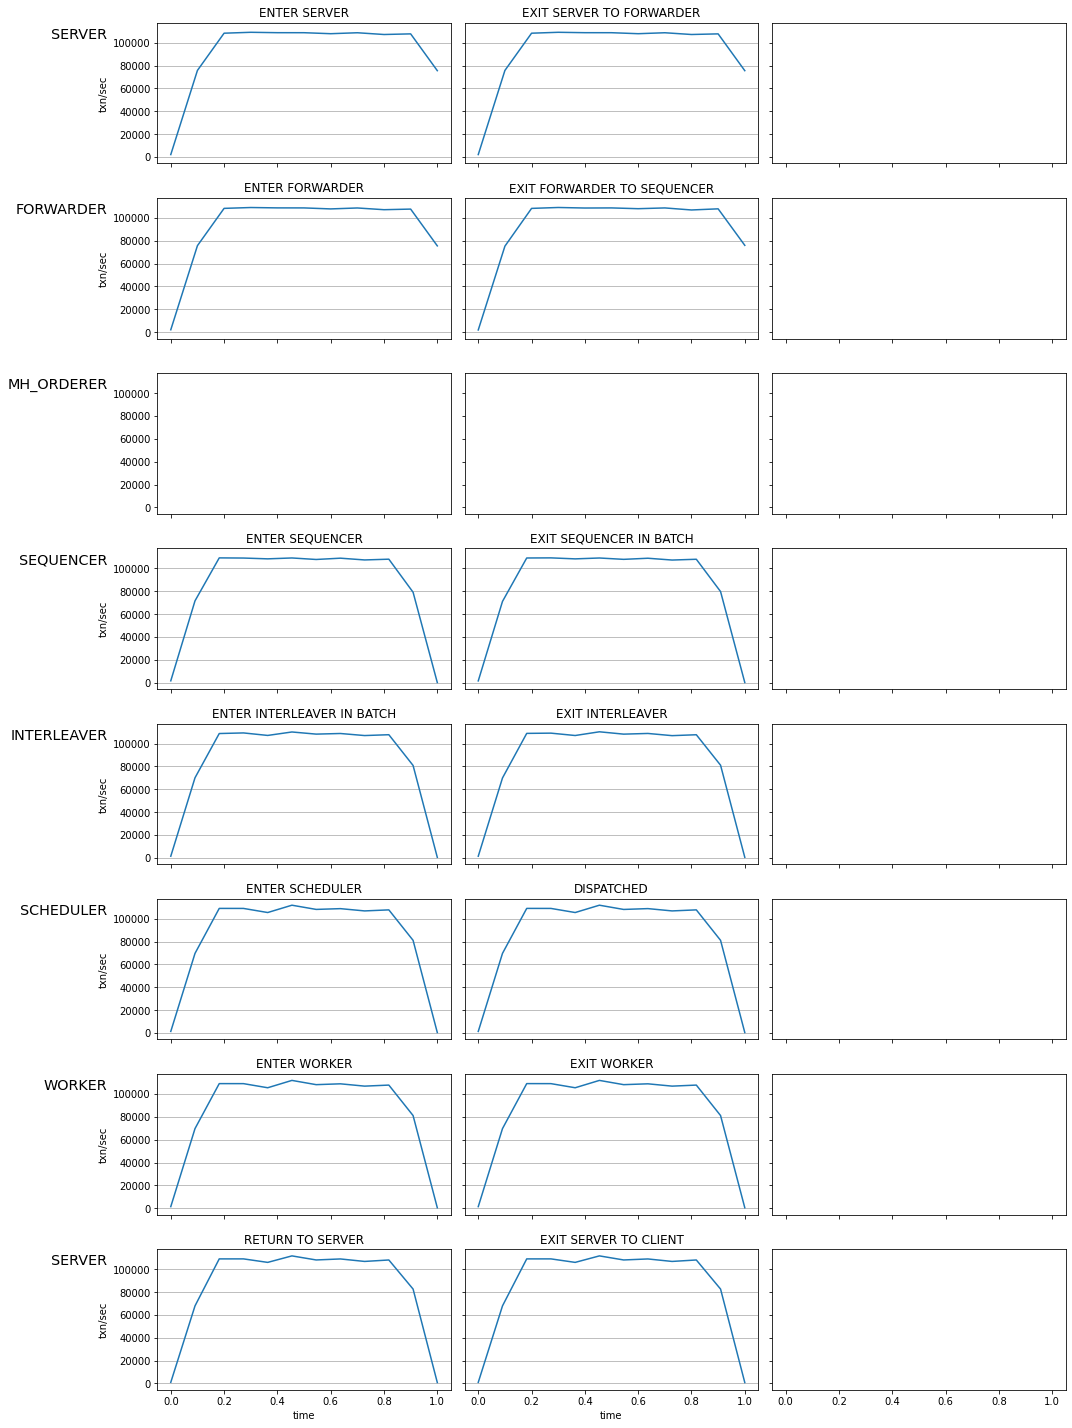

In [165]:
events = [
    'ENTER_SERVER',
    'EXIT_SERVER_TO_FORWARDER',
    '',
    'ENTER_FORWARDER',
    'EXIT_FORWARDER_TO_SEQUENCER',
    'EXIT_FORWARDER_TO_MULTI_HOME_ORDERER',
    'ENTER_MULTI_HOME_ORDERER',
    'ENTER_MULTI_HOME_ORDERER_IN_BATCH',
    'EXIT_MULTI_HOME_ORDERER',
    'ENTER_SEQUENCER',
    'EXIT_SEQUENCER_IN_BATCH',
    '',
    'ENTER_INTERLEAVER_IN_BATCH',
    'EXIT_INTERLEAVER',
    '',
    'ENTER_SCHEDULER',
    'DISPATCHED',
    '',
    'ENTER_WORKER',
    'EXIT_WORKER',
    '',
    'RETURN_TO_SERVER',
    'EXIT_SERVER_TO_CLIENT'
    '',
]

txn_time_sec_df = txn_time_df.drop(['machine', 'is_mh', 'is_mp', 'sent_at', 'received_at'], axis=1)
txn_time_sec_df = normalize(txn_time_sec_df // 1000000)

num_rows, num_cols = compute_rows_cols(len(events))
f, axes = plt.subplots(num_rows, num_cols, sharey=True, sharex=True, figsize=(15, 20))
for i, event in enumerate(events):
    if event not in txn_time_sec_df.columns:
        continue
    grouped = txn_time_sec_df.groupby(event).size() * 10
    r, c = i // num_cols, i % num_cols
    grouped.plot(
        title=event.replace('_', ' '),
        ax=axes[r, c]
    )
    axes[r, c].grid(axis='y')
    axes[r, c].set_xlabel('time')
    axes[r, c].set_ylabel('txn/sec')

    
row_labels = [
    'SERVER',
    'FORWARDER',
    'MH_ORDERER',
    'SEQUENCER',
    'INTERLEAVER',
    'SCHEDULER',
    'WORKER',
    'SERVER',
]
for ax, row in zip(axes[:,0], row_labels):
    ax.annotate(row, xy=(-50, 125), xytext=(0, 0),
                xycoords="axes points", textcoords='offset points',
                size='x-large', ha='right')
plt.tight_layout()

In [188]:
pairs = {
    'Server': ('ENTER_SERVER', 'EXIT_SERVER_TO_FORWARDER'),
    'Forwarder': ('ENTER_FORWARDER', 'EXIT_FORWARDER_TO_SEQUENCER'),
    'MH Orderer': ('ENTER_MULTI_HOME_ORDERER', 'EXIT_MULTI_HOME_ORDERER'),
    'Sequencer': ('ENTER_SEQUENCER', 'EXIT_SEQUENCER_IN_BATCH'),
    'Interleaver': ('ENTER_INTERLEAVER_IN_BATCH', 'EXIT_INTERLEAVER'),
    'Scheduler': ('ENTER_SCHEDULER', 'DISPATCHED'),
    'Worker': ('ENTER_WORKER', 'EXIT_WORKER'),
    'Server-end': ('RETURN_TO_SERVER', 'EXIT_SERVER_TO_CLIENT')
}
txn_time_parts_df = fill_common_values_and_remove_extras(txn_time_sec_df)

xticks = np.linspace(txn_time_parts_df.values.min(), txn_time_parts_df.values.max(), 10000)
volumes_df = pd.DataFrame()
for label, pair in pairs.items():
    if pair[0] not in txn_time_parts_df or pair[1] not in txn_time_parts_df:
        continue
    left_mask = txn_time_parts_df[pair[0]].to_numpy()[np.newaxis, :] <= xticks[:, np.newaxis]
    right_mask = txn_time_parts_df[pair[1]].to_numpy()[np.newaxis, :] > xticks[:, np.newaxis]
    volumes_df[label] = np.sum(left_mask & right_mask, axis=1)

volumes_df.set_index(xticks, inplace=True)

<AxesSubplot:>

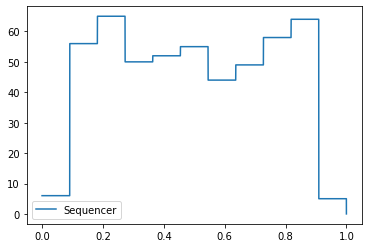

In [191]:
volumes_df.plot(y=['Sequencer'])

In [178]:
txn_time_parts_df

,DISPATCHED,ENTER_FORWARDER,ENTER_INTERLEAVER_IN_BATCH,ENTER_SCHEDULER,ENTER_SEQUENCER,ENTER_SERVER,ENTER_WORKER,EXIT_FORWARDER_TO_SEQUENCER,EXIT_INTERLEAVER,EXIT_SEQUENCER_IN_BATCH,EXIT_SERVER_TO_CLIENT,EXIT_SERVER_TO_FORWARDER,EXIT_WORKER,RETURN_TO_SERVER
txn_id,,,,,,,,,,,,,,
42500006,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
42500013,0.09091,0.10000,0.09091,0.09091,0.09091,0.10000,0.09091,0.10000,0.09091,0.09091,0.09091,0.10000,0.09091,0.09091
42500017,0.09091,0.10000,0.09091,0.09091,0.09091,0.10000,0.09091,0.10000,0.09091,0.09091,0.09091,0.10000,0.09091,0.09091
42500021,0.09091,0.10000,0.09091,0.09091,0.09091,0.10000,0.09091,0.10000,0.09091,0.09091,0.09091,0.10000,0.09091,0.09091
42500023,0.09091,0.10000,0.09091,0.09091,0.09091,0.10000,0.09091,0.10000,0.09091,0.09091,0.09091,0.10000,0.09091,0.09091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85004000,0.90909,1.00000,0.90909,0.90909,0.90909,1.00000,0.90909,1.00000,0.90909,0.90909,0.90909,1.00000,0.90909,0.90909
85004012,0.90909,1.00000,0.90909,0.90909,0.90909,1.00000,0.90909,1.00000,0.90909,0.90909,0.90909,1.00000,0.90909,0.90909
85005004,0.90909,1.00000,0.90909,0.90909,0.90909,1.00000,0.90909,1.00000,0.90909,0.90909,0.90909,1.00000,0.90909,0.90909
